In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits

from cycspec_simulator import (
    TemplateProfile,
    BasebandModel,
    FreqOnlyPredictor,
    ExponentialScatteringModel,
    Time,
    pspec_numba,
)

%matplotlib notebook

In [2]:
template_file = "B1937+21.Rcvr1_2.GUPPI.15y.x.sum.sm"
template = TemplateProfile.from_file(template_file)
template.normalize()
template.make_posdef()

Adjusting I**2 by 5.5361972783884994e-08


In [4]:
pulse_freq = 641.948222127829 # Hz
bandwidth = 1.5625e6 # Hz
predictor = FreqOnlyPredictor(pulse_freq, Time(60000, 0, 0))
model = BasebandModel(template, chan_bw=bandwidth, predictor=predictor)

In [6]:
scattering_model = ExponentialScatteringModel(scattering_time=20e-6, chan_bw=model.chan_bw, cutoff=20)
pattern = scattering_model.realize()

<IPython.core.display.Javascript object>


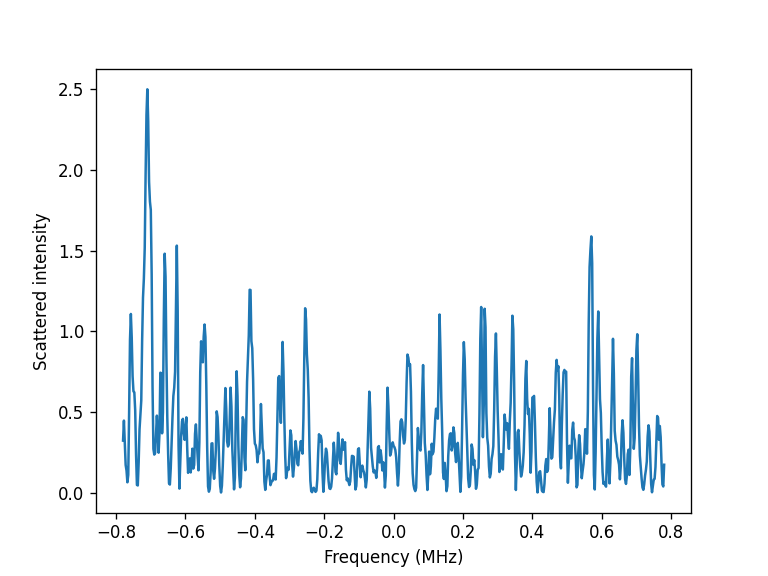

In [7]:
pattern.plot_scattered_intensity()

In [8]:
data = model.sample(2**19)

In [9]:
data = pattern.scatter(data)

In [16]:
%time pspec1 = pspec_numba(data, 128, 256, predictor, use_midpt=True)

CPU times: user 581 ms, sys: 11.5 ms, total: 592 ms
Wall time: 590 ms


In [17]:
%time pspec2 = pspec_numba(data, 128, 256, predictor, use_midpt=False)

CPU times: user 596 ms, sys: 215 µs, total: 596 ms
Wall time: 593 ms


<IPython.core.display.Javascript object>


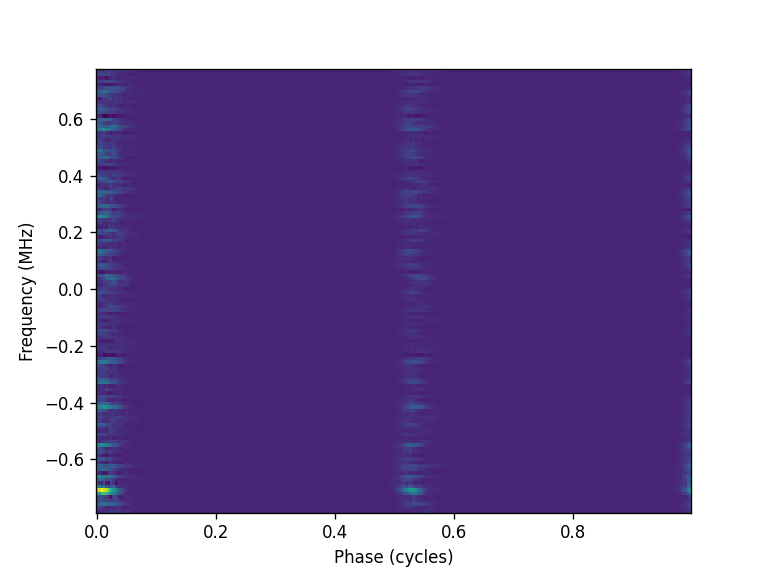

In [20]:
pspec1.plot(what='I')
plt.show()

<IPython.core.display.Javascript object>


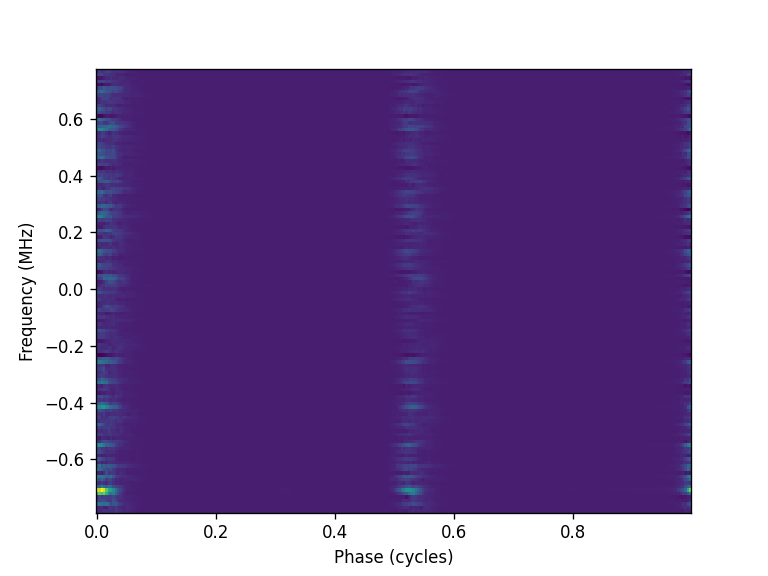

In [21]:
pspec2.plot(what='I')
plt.show()

<IPython.core.display.Javascript object>


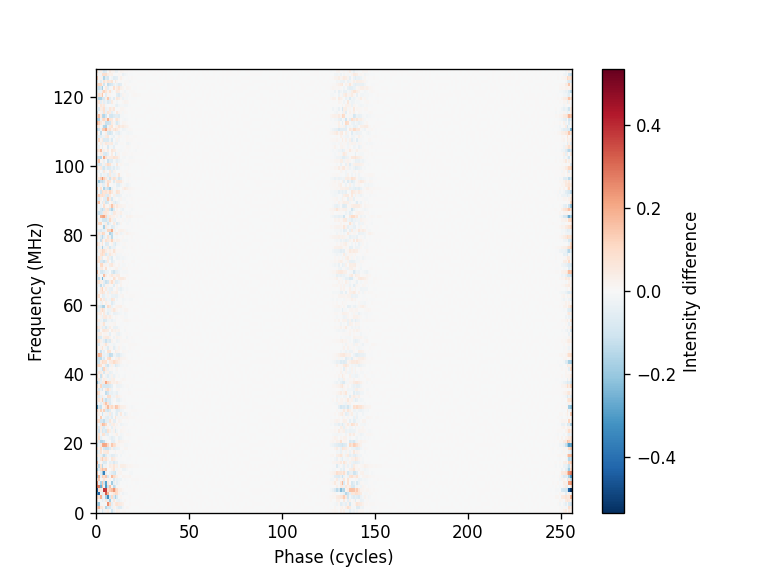

In [22]:
diff = pspec1.I - pspec2.I
lim = max(-np.min(diff), np.max(diff))
pc = plt.pcolormesh(diff, cmap='RdBu_r', vmin=-lim, vmax=lim)
cb = plt.colorbar(pc)
plt.xlabel('Phase (cycles)')
plt.ylabel('Frequency (MHz)')
cb.set_label('Intensity difference')
plt.show()

<IPython.core.display.Javascript object>


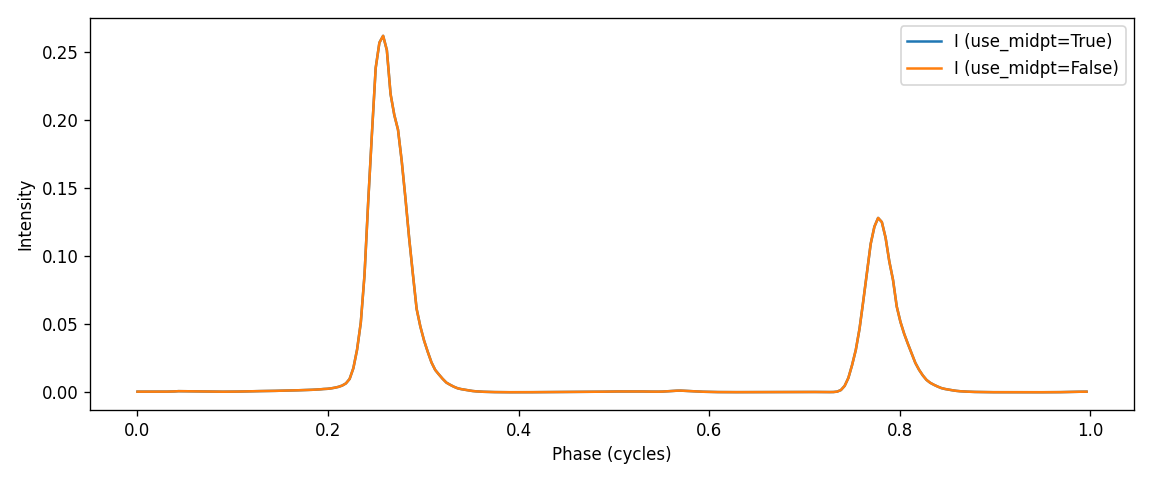

In [23]:
fig, ax = plt.subplots(figsize=(9.6, 4.0))
#plt.plot(pspec1.phase, np.roll(template.resample(256).I, 256//4), label='I (injected)')
plt.plot(pspec1.phase, np.roll(np.mean(pspec1.I, axis=0), 256//4), label='I (use_midpt=True)')
plt.plot(pspec2.phase, np.roll(np.mean(pspec2.I, axis=0), 256//4), label='I (use_midpt=False)')
plt.legend()
plt.xlabel("Phase (cycles)")
plt.ylabel("Intensity")
plt.tight_layout()
plt.show()